# Import and setup

In [1]:
import json
import re
import pandas as pd
import numpy as np
import dask.bag as db
from matplotlib import pyplot as plt
from pylab import rcParams
from matplotlib import rc
import seaborn as sns

In [2]:
rcParams['figure.figsize'] = 15, 6
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)
%matplotlib inline

# Look at the arxiv metadata

In [3]:
info = db.read_text("arxiv-metadata-oai-snapshot.json").map(json.loads)
info.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Look at the number of submissions as a function of time

In [4]:
first_v = lambda x: x['versions'][0]['created']
first_v(info.take(1)[0])

'Mon, 2 Apr 2007 19:18:42 GMT'

In [5]:
dates_freq = info.map(first_v).frequencies(sort=True)
dates_df = dates_freq.to_dataframe(columns = ['sub_datetime', 'num_sub']).compute()
date_format = '%a, %d %b %Y %H:%M:%S %Z'
dates_df['sub_datetime'] = pd.to_datetime(dates_df.sub_datetime, format = date_format)
dates_df['sub_year'] = dates_df.sub_datetime.dt.year
dates3 = dates_df.groupby('sub_year').sum().reset_index()

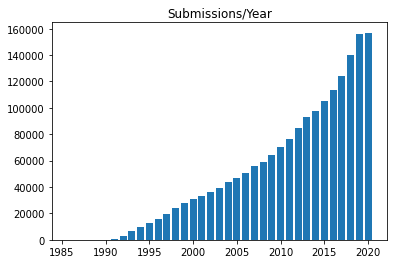

In [6]:
plt.bar(dates3['sub_year'], dates3['num_sub'])
plt.title('Submissions/Year')
plt.show()

## Keep papers from two 3-year timespans separated 10 years apart: [2008, 2009, 2010] and [2018, 2019, 2020]. (also keep my papers)

In [7]:
trim = lambda x: {'id': x['id'],
                  'category': x['categories'].split(' '),
                 'abstract': x['abstract']}

In [8]:
info_spans = info.filter(lambda x: int(first_v(x).split(' ')[3]) in [2008, 2009, 2010, 2018, 2019, 2020]).map(trim).compute()

In [9]:
info_me = info.filter(lambda x: ['Schillo', 'Marjorie', ''] 
                      in x['authors_parsed']).map(trim).compute()

In [10]:
submissions = pd.DataFrame(info_spans)
my_submissions = pd.DataFrame(info_me)

submissions['year'] = submissions.id.apply(lambda x: x[:2])
submissions = submissions[submissions.year.apply(lambda x: x in ['08', '09', '10', '18', '19', '20'])]
my_submissions['year'] = my_submissions.id.apply(lambda x: x[:2])

In [11]:
print(f'{submissions.shape[0]} papers for 2008, 2009, 2010, 2018, 2019, 2020')
print(f'{my_submissions.shape[0]} papers for me')

646095 papers for 2008, 2009, 2010, 2018, 2019, 2020
13 papers for me


### Only look at general category containing all sub-categories

In [12]:
submissions['category'] = submissions.category.apply(lambda x: [a.split('.')[0] for a in x])
my_submissions['category'] = my_submissions.category.apply(lambda x: [a.split('.')[0] for a in x])
submissions['category'] = submissions.category.apply(lambda x: list(dict.fromkeys(x)))
my_submissions['category'] = my_submissions.category.apply(lambda x: list(dict.fromkeys(x)))

### Separate categories into submission category and cross-lists

In [13]:
submissions['cross_lists']=submissions.category.apply(lambda x: x[1:])
submissions['category']=submissions.category.apply(lambda x: x[0])

my_submissions['cross_lists']=my_submissions.category.apply(lambda x: x[1:])
my_submissions['category']=my_submissions.category.apply(lambda x: x[0])

## look at number of submissions per category per year

In [14]:
catcounts = submissions.groupby(['year', 'category'])['id'].count()
catcounts.head(18)

year  category
08    astro-ph    10127
      cond-mat    10239
      cs           3256
      gr-qc        1867
      hep-ex        923
      hep-lat       515
      hep-ph       4169
      hep-th       3318
      math        12246
      math-ph      1256
      nlin          760
      nucl-ex       550
      nucl-th      1047
      physics      3870
      q-bio         713
      q-fin         285
      quant-ph     3070
      stat          456
Name: id, dtype: int64

#### Set a minimum number of submissions needed per year to keep a category

In [15]:
MIN_CAT = 500

In [16]:
allcategories = list(submissions.category.unique())
keepcategories = allcategories.copy()

catcounts_cut=catcounts[catcounts > MIN_CAT]
catsperyear=[list(catcounts_cut[yr].index) for yr in list(catcounts_cut.index.unique(level=0))]

In [17]:
for i in range(len(catsperyear)):
    keepcategories = [x for x in keepcategories if x in catsperyear[i]]

removedcategories = [x for x in allcategories if x not in keepcategories]
print(f'categories kept: {keepcategories}')
print(f'categories removed: {removedcategories}')

categories kept: ['math', 'astro-ph', 'hep-ph', 'math-ph', 'hep-th', 'physics', 'quant-ph', 'cs', 'cond-mat', 'nlin', 'q-bio', 'nucl-th', 'hep-ex', 'gr-qc']
categories removed: ['hep-lat', 'nucl-ex', 'stat', 'q-fin', 'eess', 'econ']


### only keep those categories and balance the dataset

In [18]:
submissionscut = submissions[submissions.category.apply(lambda x: x in keepcategories)]
print(f'{submissions.shape[0]} papers initially')
print(f'{submissionscut.shape[0]} papers after removing small categories')

646095 papers initially
603407 papers after removing small categories


In [19]:
arxiv_sample = submissionscut.groupby(['year', 'category']).sample(n=MIN_CAT, random_state=RANDOM_SEED)

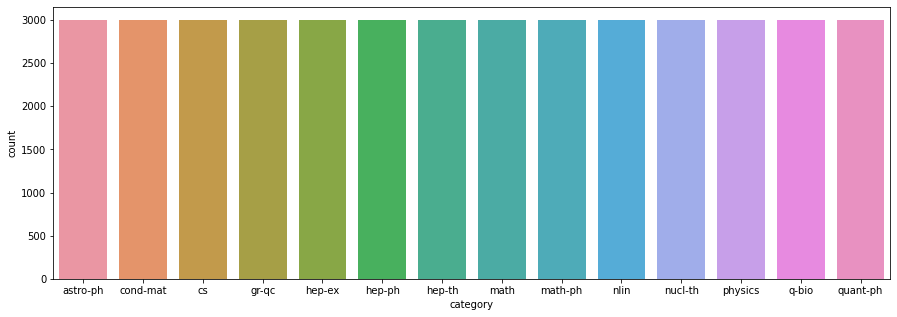

In [20]:
plt.figure(figsize=(15,5))
sns.countplot(x=arxiv_sample.category)
plt.xlabel('category');

# CLEAN
- remove newline characters
- rewrite $LaTeX$ as 'equation'
- replace all greek letters with 'letter'
- remove special characters

In [21]:
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace('\n', ' ') 
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'\$(.+?)\$', 'equation', regex=True)
greek = [r'\\alpah', r'\\beta', r'\\gamma', r'\\delta', r'\\epsilon', r'\\zeta', r'\\theta', r'\\eta', r'\\iota', r'\\kappa', r'\\lambda', r'\\mu', r'\\nu', r'\\xi', r'\\omicron', r'\\pi', r'\\rho', r'\\sigma', r'\\tau', r'\\upsilon', r'\\phi', r'\\chi', r'\\psi', r'\\omega']
Greek = [r'\\Alpah', r'\\Beta', r'\\Gamma', r'\\Delta', r'\\Epsilon', r'\\Zeta', r'\\Theta', r'\\Eta', r'\\Iota', r'\\Kappa', r'\\Lambda', r'\\Mu', r'\\Nu', r'\\Xi', r'\\Omicron', r'\\Pi', r'\\Rho', r'\\Sigma', r'\\Tau', r'\\Upsilon', r'\\Phi', r'\\Chi', r'\\Psi', r'\\Omega']
for letter in greek + Greek:
    arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(letter, 'letter', regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'[\|\{\}]', '', regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'\`\`', r"'", regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'\'\'', r"'", regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'[\^\_\+]', '', regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'\\"o', 'o', regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'\\"a', 'a', regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'\\"u', 'u', regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'\\pm', '', regex=True)
arxiv_sample['abstract'] = arxiv_sample.abstract.str.replace(r'-->', 'to', regex=True)
arxiv_sample['abstract'] = arxiv_sample['abstract'].str[2:-1]

In [22]:
my_submissions['abstract'] = my_submissions.abstract.str.replace('\n', ' ') 
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'\$(.+?)\$', 'equation', regex=True)
greek = [r'\\alpah', r'\\beta', r'\\gamma', r'\\delta', r'\\epsilon', r'\\zeta', r'\\theta', r'\\eta', r'\\iota', r'\\kappa', r'\\lambda', r'\\mu', r'\\nu', r'\\xi', r'\\omicron', r'\\pi', r'\\rho', r'\\sigma', r'\\tau', r'\\upsilon', r'\\phi', r'\\chi', r'\\psi', r'\\omega']
Greek = [r'\\Alpah', r'\\Beta', r'\\Gamma', r'\\Delta', r'\\Epsilon', r'\\Zeta', r'\\Theta', r'\\Eta', r'\\Iota', r'\\Kappa', r'\\Lambda', r'\\Mu', r'\\Nu', r'\\Xi', r'\\Omicron', r'\\Pi', r'\\Rho', r'\\Sigma', r'\\Tau', r'\\Upsilon', r'\\Phi', r'\\Chi', r'\\Psi', r'\\Omega']
for letter in greek + Greek:
    my_submissions['abstract'] = my_submissions.abstract.str.replace(letter, 'letter', regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'[\|\{\}]', '', regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'\`\`', r"'", regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'\'\'', r"'", regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'[\^\_\+]', '', regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'\\"o', 'o', regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'\\"a', 'a', regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'\\"u', 'u', regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'\\pm', '', regex=True)
my_submissions['abstract'] = my_submissions.abstract.str.replace(r'-->', 'to', regex=True)
my_submissions['abstract'] = my_submissions['abstract'].str[2:-1]

# Make training sets

### Add an int to represent a category

In [23]:
def cat_to_int_label(cat):
 for i in range(len(keepcategories)):
    if cat == keepcategories[i]:
      return i

In [24]:
arxiv_sample['cat_int'] = arxiv_sample.category.apply(cat_to_int_label)
my_submissions['cat_int'] = my_submissions.category.apply(cat_to_int_label)

In [25]:
arxiv_080910 = arxiv_sample[arxiv_sample.year.apply(lambda x: x in ['08', '09' ,'10'])]
arxiv_181920 = arxiv_sample[arxiv_sample.year.apply(lambda x: x in ['18', '19', '20'])]

In [30]:
arxiv_080910_single_cat = arxiv_080910[arxiv_080910.cross_lists.apply(lambda x: len(x) == 0)]
arxiv_181920_single_cat = arxiv_181920[arxiv_181920.cross_lists.apply(lambda x: len(x) == 0)]

In [33]:
arxiv_080910.to_csv('arxiv_080910.csv', index=False, header=True)
arxiv_181920.to_csv('arxiv_181920.csv', index=False, header=True)
arxiv_080910_single_cat.to_csv('arxiv_080910_sincat.csv', index=False, header=True)
arxiv_181920_single_cat.to_csv('arxiv_181920_sincat.csv', index=False, header=True)
my_submissions.to_csv('my_papers.csv', index=False, header=True)

In [31]:
arxiv_080910_single_cat.iloc[0]

id                                                     0812.2496
category                                                astro-ph
abstract       The disk instability mechanism for giant plane...
year                                                          08
cross_lists                                                   []
cat_int                                                        1
Name: 56046, dtype: object